# Advanced Data Augmentation with Keras 

- Implement various data augmentation techniques using Keras 
- Implement feature-wise and sample-wise normalization on the data set. 
- Define and apply a custom augmentation function that adds random noise to images. 
- Display the augmented images to understand the effect of different augmentation techniques.  

##### Step 1: Setup the environment

In [1]:
!pip install tensorflow==2.16.2 
!pip install matplotlib==3.9.1 
!pip install scipy

^C
  Using cached tensorflow-2.16.2-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.16.2-cp39-cp39-win_amd64.whl.metadata (5.0 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.2-cp39-cp39-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.2-cp39-cp39-win_amd64.whl (376.9 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow-intel
    Found existing installation: tensorflow-intel 2.17.1
    Uninstalling tensorflow-intel-2.17.1:
      Successfully uninstalled tensorflow-intel-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
^C
  Using cached matplotlib-3.9.1.ta

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [22 lines of output]
      + meson setup C:\Users\sekai\AppData\Local\Temp\pip-install-mn_47f90\matplotlib_deb92e107a5649a7b742f03a07d70c9c C:\Users\sekai\AppData\Local\Temp\pip-install-mn_47f90\matplotlib_deb92e107a5649a7b742f03a07d70c9c\.mesonpy-4_z9ale_ -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\sekai\AppData\Local\Temp\pip-install-mn_47f90\matplotlib_deb92e107a5649a7b742f03a07d70c9c\.mesonpy-4_z9ale_\meson-python-native-file.ini
      The Meson build system
      Version: 1.8.4
      Source dir: C:\Users\sekai\AppData\Local\Temp\pip-install-mn_47f90\matplotlib_deb92e107a5649a7b742f03a07d70c9c
      Build dir: C:\Users\sekai\AppData\Local\Temp\pip-install-mn_47f90\matplotlib_deb92e107a5649a7b742f03a07d70c9c\.mesonpy-4_z9ale_
      Build type: native build
      Program python3 found: YES
      Project name: matplotlib
  

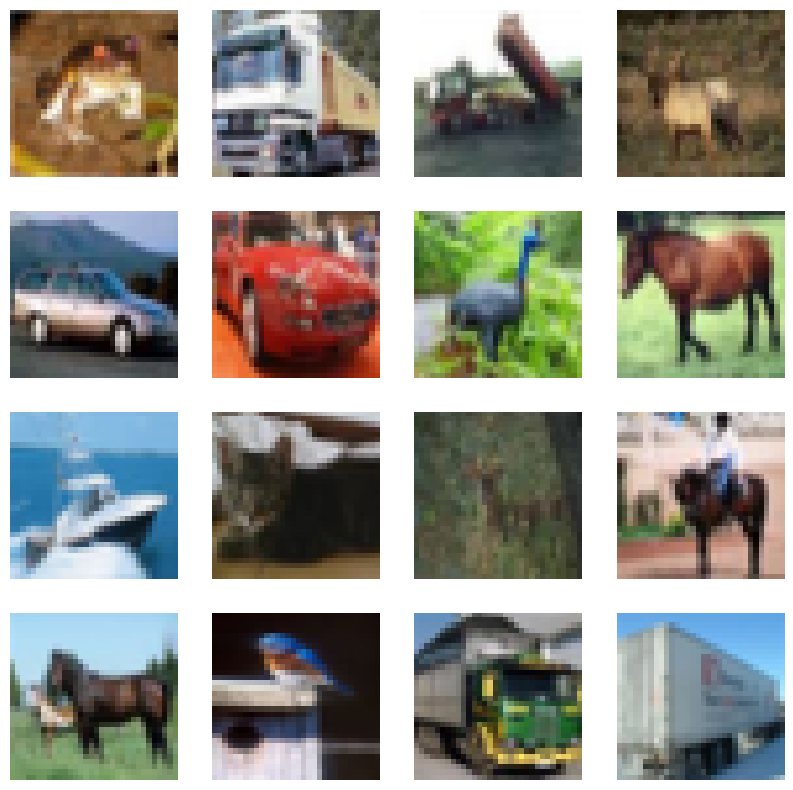

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CIFAR-10 dataset for training images.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values for augmentation
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Display a sample of the training images
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

In [7]:
from PIL import Image, ImageDraw

# Create a blank white image
image = Image.new('RGB', (224, 224), color = (255, 255, 255))

# Draw a red square
draw = ImageDraw.Draw(image)
draw.rectangle([(50, 50), (174, 174)], fill=(255, 0, 0))

# Save the image
image.save('sample.jpg')


In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 

# Load a sample image 
img_path = 'sample.jpg' 
img = load_img(img_path) 
x = img_to_array(img) 
print(x)
x = np.expand_dims(x, axis=0) 

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]


##### Step 2: Basic data augmentation

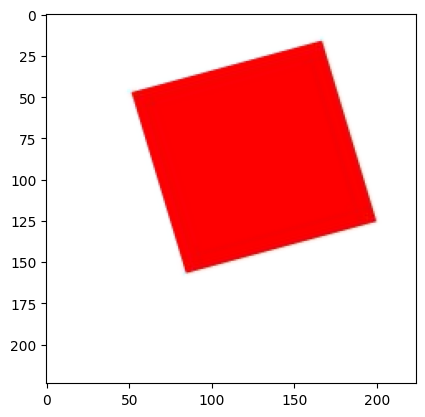

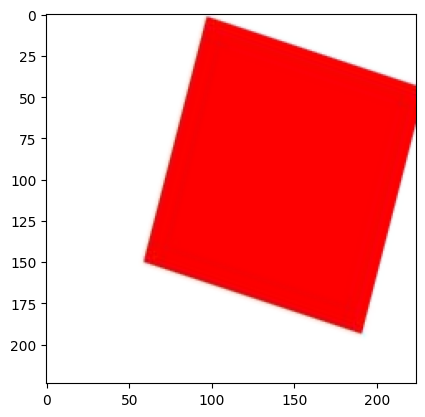

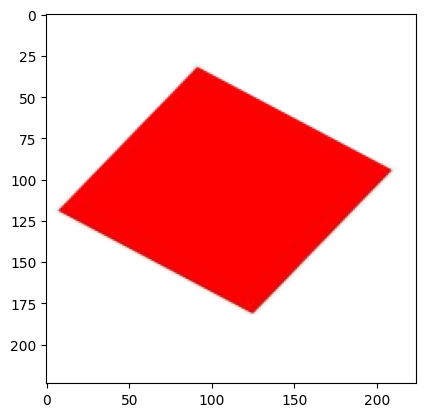

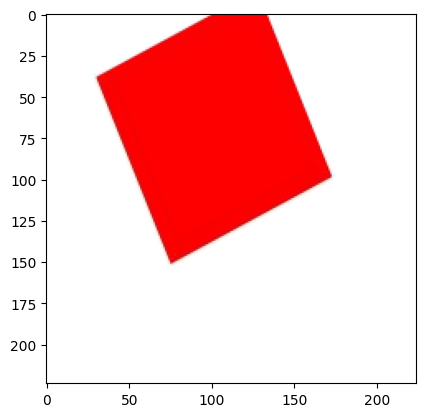

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load the sample image
img_path = 'sample.jpg'
img = load_img(img_path)
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

# Create an instance of ImageDataGenerator with basic augmentations
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate batches of augmented images
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0].astype('uint8'))
    i += 1
    if i % 4 == 0:
        break

plt.show()


##### Step 3: Feature-wise and sample-wise normalization

Implement feature-wise and sample-wise normalization on the dataset as follows:

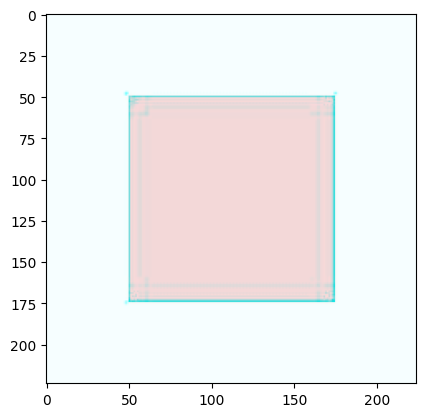

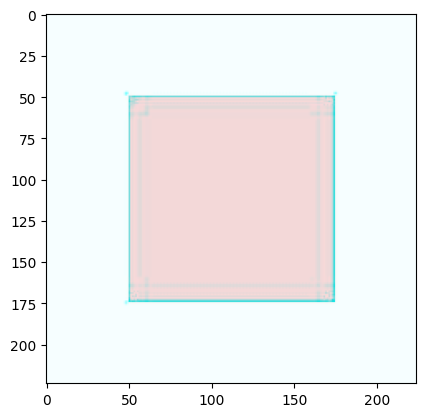

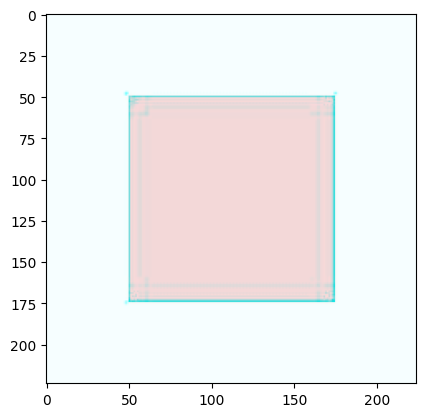

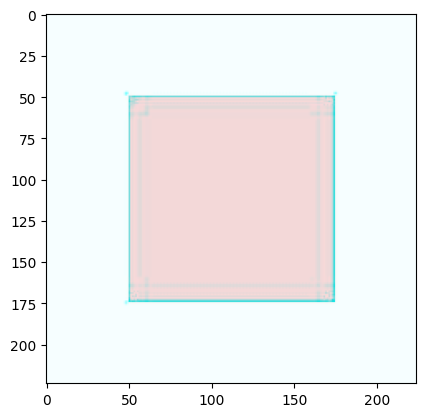

In [14]:
# Option 1: Use only featurewise normalization
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Option 2: Use only samplewise normalization  
# datagen = ImageDataGenerator(
#     samplewise_center=True,
#     samplewise_std_normalization=True
# )

datagen.fit(x)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    
    # Properly handle normalized values for display
    img = batch[0]
    # Rescale to 0-1 range for display
    img_display = (img - img.min()) / (img.max() - img.min())
    
    plt.imshow(img_display)
    i += 1
    if i % 4 == 0:
        break

plt.show()

##### Step 4: Custom data augmentation function

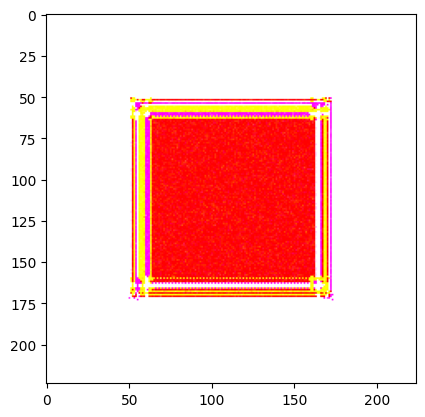

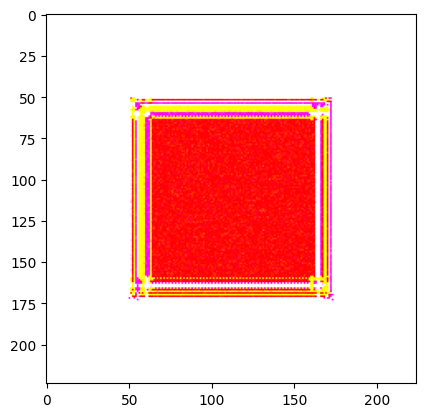

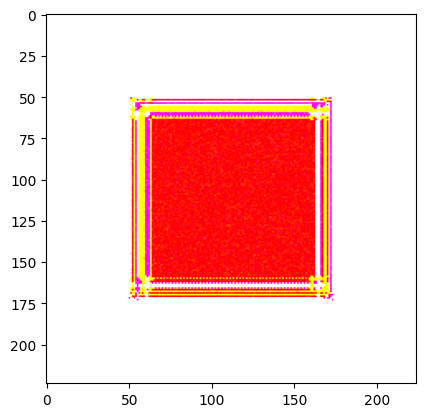

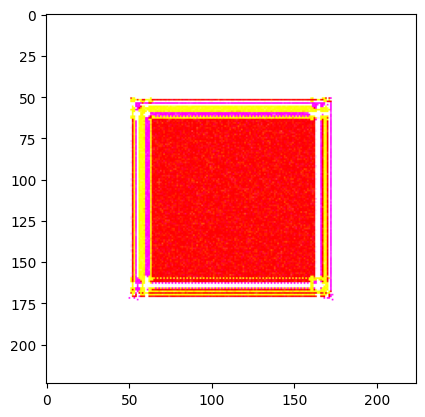

In [15]:
def add_random_noise(image):
    # Assume image is in 0-1 range (typical for normalized images)
    noise = np.random.normal(0, 0.1, image.shape)
    noisy_image = image + noise
    # Clip to valid range
    return np.clip(noisy_image, 0, 1)

datagen = ImageDataGenerator(preprocessing_function=add_random_noise)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    # No need for uint8 conversion if image is in 0-1 range
    plt.imshow(batch[0])
    i += 1
    if i % 4 == 0:
        break

plt.show()

##### Step 5: Visualize augmented images

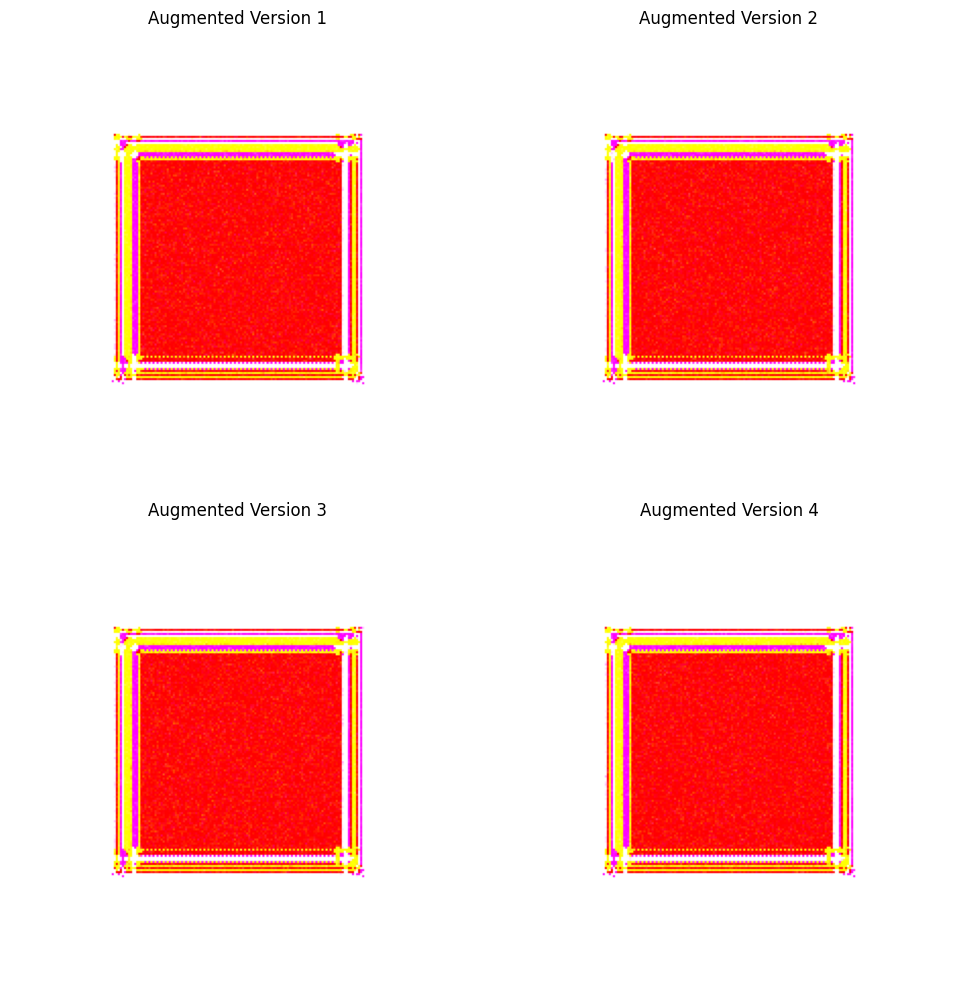

In [17]:
# Visualizing multiple augmented versions of the same image
plt.figure(figsize=(10, 10))
for i, batch in enumerate(datagen.flow(x, batch_size=1)):
    if i >= 4:  # Show only 4 versions
        break
    plt.subplot(2, 2, i+1)
    
    # Handle display properly based on your image range
    img = batch[0]
    if img.max() <= 1.0:  # Image is in 0-1 range
        plt.imshow(img)
    else:  # Image is in 0-255 range
        plt.imshow(img.astype('uint8'))
    
    plt.title(f'Augmented Version {i+1}')
    plt.axis('off')  # Optional: remove axes for cleaner look

plt.tight_layout()
plt.show()

##### More...

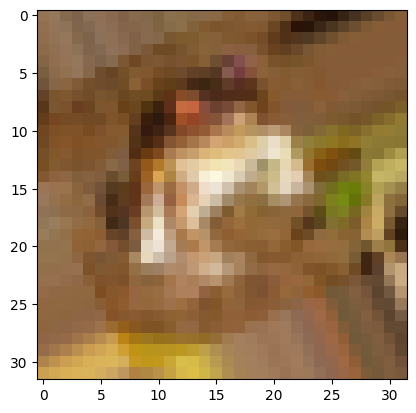

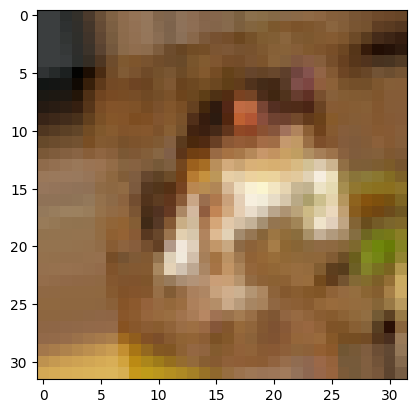

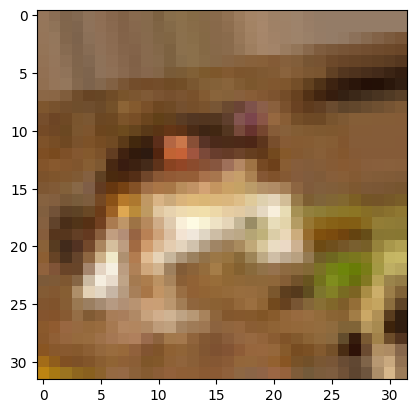

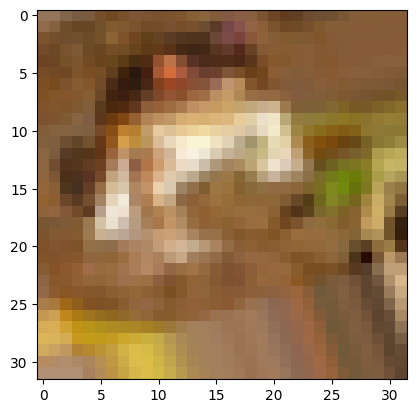

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values for augmentation
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Create an instance of ImageDataGenerator with normalization options
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Use a single CIFAR-10 image for augmentation demo
# Pick one image from the training set
single_image = np.expand_dims(x_train[0], axis=0)  # Shape: (1, 32, 302, 3)

# Fit the generator (though not necessary for these augmentations)
datagen.fit(single_image)

# Generate batches of normalized images
i = 0
for batch in datagen.flow(single_image, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 4 == 0:
        break

plt.show()


Featurewise Normalization:


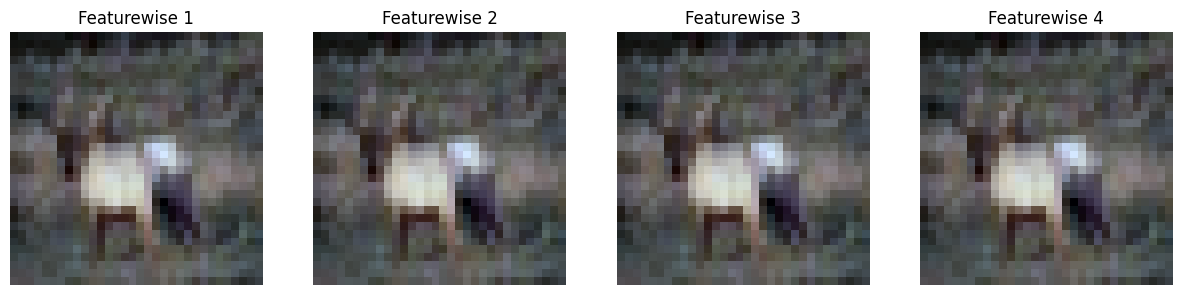

Samplewise Normalization:


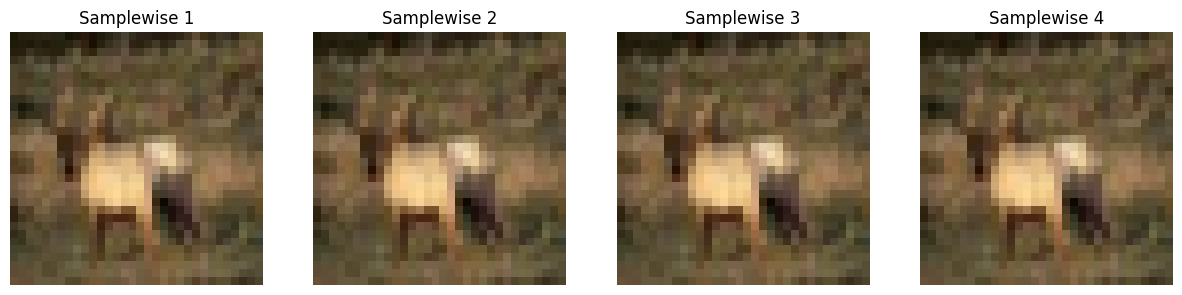

In [27]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the pixel values 
x_train = x_train.astype('float32') / 255.0

# Use a single CIFAR-10 image
single_image = np.expand_dims(x_train[3], axis=0)  # Shape: (1, 32, 32, 3)

# Create ImageDataGenerator with featurewise normalization
datagen_featurewise = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

# Create ImageDataGenerator with samplewise normalization  
datagen_samplewise = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Fit only the featurewise generator (samplewise doesn't need fit)
datagen_featurewise.fit(single_image)

# Visualize featurewise normalization results
print("Featurewise Normalization:")
plt.figure(figsize=(15, 4))
i = 0
for batch in datagen_featurewise.flow(single_image, batch_size=1):
    plt.subplot(1, 4, i+1)
    # Properly handle normalized values for display
    img = batch[0]
    img_display = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img_display)
    plt.title(f'Featurewise {i+1}')
    plt.axis('off')
    i += 1
    if i >= 4:
        break
plt.show()

# Visualize samplewise normalization results  
print("Samplewise Normalization:")
plt.figure(figsize=(15, 4))
i = 0
for batch in datagen_samplewise.flow(single_image, batch_size=1):
    plt.subplot(1, 4, i+1)
    # Properly handle normalized values for display
    img = batch[0]
    img_display = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img_display)
    plt.title(f'Samplewise {i+1}')
    plt.axis('off')
    i += 1
    if i >= 4:
        break
plt.show()

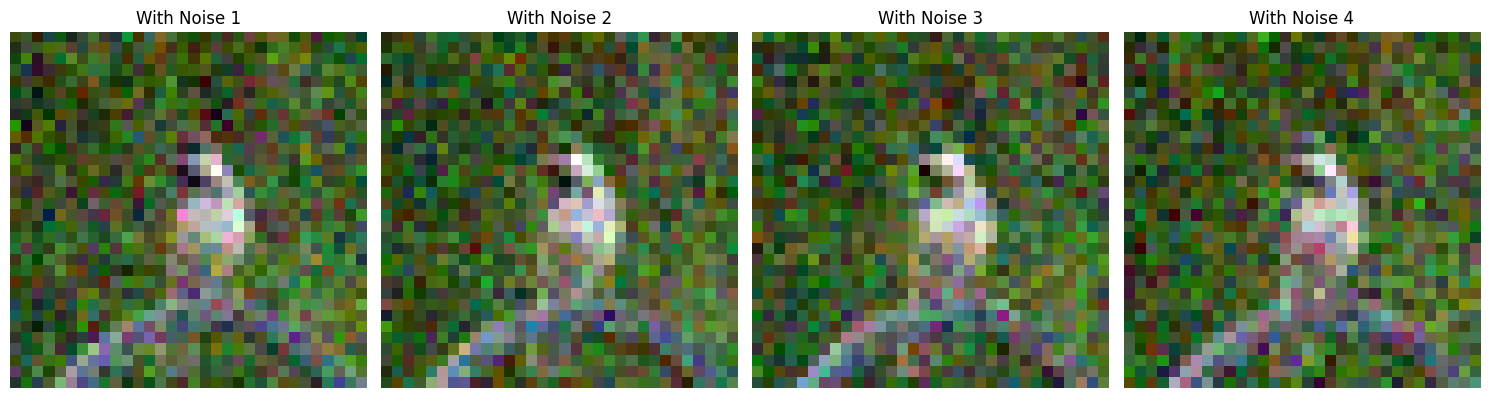

In [29]:
import numpy as np

# Define a custom data augmentation function
def add_random_noise(image):
    """
    Add random Gaussian noise to an image
    Assumes image values are in 0-1 range
    """
    noise = np.random.normal(0, 0.1, image.shape)  # mean=0, std=0.1
    noisy_image = image + noise
    # Clip to valid range to prevent overflow
    return np.clip(noisy_image, 0, 1)

# Create an instance of ImageDataGenerator with the custom augmentation
datagen = ImageDataGenerator(preprocessing_function=add_random_noise)

# Use the same CIFAR-10 setup from before
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0

# Use a single CIFAR-10 image
single_image = np.expand_dims(x_train[54], axis=0)

# Generate batches of images with added noise
plt.figure(figsize=(15, 4))
i = 0
for batch in datagen.flow(single_image, batch_size=1):
    plt.subplot(1, 4, i+1)
    plt.imshow(batch[0])  # No need for uint8 conversion
    plt.title(f'With Noise {i+1}')
    plt.axis('off')
    i += 1
    if i >= 4:
        break

plt.tight_layout()
plt.show()